# **Reinforcement Learning (COMP-767) Assignment 1**
## Student 1:
## Name: Bhavya Patwa
### McGill ID: 260964036
### email ID: bhavya.patwa@mail.mcgill.ca
## Student 2:
## Name: Yifan Bai
### McGill ID: 260562421
### email ID: yifan.bai@mail.mcgill.ca

### **Statement of Contribution**


Both team members contributed equally to reviewing each other's answers and brainstorming. The team then split the questions and assigned principal person-in-charge for coding each question. Bhavya was in charge of Question 1 and Yifan for Question 2. The formatting of this notebook was done together by both team members

### **Question 1.**

####Track A

In [0]:
import numpy as np
from matplotlib import pyplot as plt

##### **Bandit**

In [0]:
class Bandit:
  
  def __init__(self,arms_mean=0,arms_var=1,num_arms=10):
    
    self.arms_mean = arms_mean
    self.arms_var = arms_var
    self.k = num_arms
    
    self.means = np.random.normal(self.arms_mean, self.arms_var, size=(self.k,))

    self.reset()

  def reset(self):
    # self.means = np.random.normal(self.arms_mean, self.arms_var, size=(self.k,))
    # Q(A) and N(A)
    self.action_values = np.zeros((self.k,))
    self.action_counts = np.zeros((self.k,))

  # running average
  def update_means(self,arm_idx,value):
    self.action_values[arm_idx] += (1 / self.action_counts[arm_idx]) * (value - self.action_values[arm_idx])
  
  def compute_regret(self,value):
    regret = np.amax(self.means) - value
    return regret
  
  def pull_arm(self, arm_idx,test=False):
    # arm_idx = A_t
    value = np.random.normal(self.means[arm_idx], scale=1.0) # explore
    if not test:
      self.action_counts[arm_idx] += 1
      self.update_means(arm_idx, value)
    return value

In [0]:
class Log:

  def __init__(self):
    self.action_log = []
    self.reward_log = []
    self.regret_log = []
    self.test_reward_log = []
  
  def record_log(self,action=None,reward=None,regret=None):
    self.action_log.append(action)
    self.reward_log.append(reward)
    self.regret_log.append(regret)

  def record_test_log(self,test_reward=None):
    self.test_reward_log.append(test_reward)
    
  def get_logs(self):
    return self.action_log, self.reward_log, self.regret_log, self.test_reward_log

##### **Epsilon Greedy**

In [0]:
def epsilon_greedy(bandit,epsilon=0.1):
  # explore or exploit
  iterations = 1000
  log = Log()

  for i in range(1,iterations + 1):
    p = np.random.uniform()
    if p < epsilon:
      explore_arm_idx = np.random.randint(bandit.k)
      arm_idx = explore_arm_idx
      value = bandit.pull_arm(explore_arm_idx)
    else:
      arm_idx = np.argmax(bandit.action_values)
      value = bandit.pull_arm(arm_idx)
    regret = bandit.compute_regret(value)
    # testing
    def test():
      np.random.seed(i)
      arm_idx = np.argmax(bandit.action_values)
      value = bandit.pull_arm(arm_idx,test=True)
      return value
    if i%10==0:
      avg_test_reward = np.mean([test() for j in range(5)])
      log.record_test_log(test_reward=avg_test_reward)
    log.record_log(action=arm_idx,reward=value,regret=regret)
  return log.get_logs()

##### **Softmax**

In [0]:
def softmax(means,temp=1):
  probs = np.exp(means/temp)
  probs = probs/np.sum(probs)
  return probs

def softmax_exploration(bandit,T=1):
  # control exploration or exploitation based on Temperature T
  iterations = 1000
  log = Log()
  for i in range(1,iterations + 1):
    p = softmax(bandit.action_values,T)
    arm_idx = np.random.choice(a=bandit.k,p=p)
    value = bandit.pull_arm(arm_idx)
    regret = bandit.compute_regret(value)
    # testing
    def test():
      np.random.seed(i)
      arm_idx = np.argmax(bandit.action_values)
      value = bandit.pull_arm(arm_idx,test=True)
      return value
    if i%10==0:
      avg_test_reward = np.mean([test() for j in range(5)])
      # print(avg_test_reward)
      log.record_test_log(test_reward=avg_test_reward)
    log.record_log(action=arm_idx,reward=value,regret=regret)
  return log.get_logs()

##### **UCB**

In [0]:
def UCB_algorithm(bandit,c=1):
  iterations = 1000
  log = Log()
  bandit.action_counts += 1
  for i in range(1,iterations + 1):
    arm_idx = np.argmax(bandit.action_values + c * np.sqrt(np.log(i)/bandit.action_counts))
    value = bandit.pull_arm(arm_idx)
    regret = bandit.compute_regret(value)
    # testing
    def test():
      np.random.seed(i)
      arm_idx = np.argmax(bandit.action_values)
      value = bandit.pull_arm(arm_idx,test=True)
      return value
    if i%10==0:
      avg_test_reward = np.mean([test() for j in range(5)])
      log.record_test_log(test_reward=avg_test_reward)
    log.record_log(action=arm_idx,reward=value,regret=regret)
  return log.get_logs()

##### **Thompson**

In [0]:
def thompson_sampling(bandit,sigma0=1): # sigma0 = σ_0^2
  iterations = 1000
  log = Log()
  posterior_mean = np.zeros(bandit.k)
  posterior_var = np.ones(bandit.k)

  for i in range(1,iterations + 1):

    #sampling from the posterior
    theta = np.random.normal(loc=posterior_mean,scale=np.sqrt(posterior_var))

    # select arm and take action
    arm_idx = np.argmax(posterior_mean)
    value = bandit.pull_arm(arm_idx)
    regret = bandit.compute_regret(value)

    # update posterior
    posterior_mean[arm_idx] = (posterior_var[arm_idx]*posterior_mean[arm_idx] + sigma0*value)/(posterior_var[arm_idx] + sigma0)

    # testing
    def test():
      np.random.seed(i)
      arm_idx = np.argmax(posterior_mean)
      value = bandit.pull_arm(arm_idx,test=True)
      return value
    if i%10==0:
      avg_test_reward = np.mean([test() for j in range(5)])
      log.record_test_log(test_reward=avg_test_reward)
    log.record_log(action=arm_idx,reward=value,regret=regret)
  return log.get_logs()

##### **Plots**

In [0]:
def plot_run(runs):
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,figsize=(20, 12))
  # plt.subplot(3,1,1)
  ax1.set_xlabel("Steps", fontweight='bold')
  ax1.set_ylabel("Average reward", fontweight='bold')
  # plt.subplot(3,1,2)
  ax2.set_xlabel("Steps", fontweight='bold')
  ax2.set_ylabel("Average regret per step", fontweight='bold')
  # plt.subplot(3,1,3)
  ax3.set_xlabel("Steps", fontweight='bold')
  ax3.set_ylabel("Average test reward per 10 steps", fontweight='bold')
  for algo,run in runs.items():
    if algo == 'e-greedy':
      hparam_name = 'e'
    if algo == 'softmax':
      hparam_name = 'T'
    if algo == 'UCB':
      hparam_name = 'c'
    if algo == 'Thompson':
      hparam_name = 'σ_0^2'
    for hparam,logs in run.items():
      # print(len(logs[1]))
      # [print(len(logs[1][i])) for i in range(10)]
      avg_reward = np.mean(logs[1],axis=0)
      avg_regret = np.mean(logs[2],axis=0)
      avg_test_reward = np.mean(logs[3],axis=0)
      # print(avg_reward.shape,hparam)
      # plt.subplot(3,1,1)
      ax1.plot(np.arange(avg_reward.shape[0]),avg_reward,label='%s: %s={%0.2f}'%(algo,hparam_name,hparam))
      # plt.subplot(3,1,2)
      ax2.plot(np.arange(avg_regret.shape[0]),avg_regret,label='%s: %s={%0.2f}'%(algo,hparam_name,hparam))
      # plt.subplot(3,1,3)
      ax3.plot(np.arange(start=10,stop=1001,step=10),avg_test_reward,label='%s: %s={%0.2f}'%(algo,hparam_name,hparam))
  # plt.subplot(3,1,1)
  ax1.legend(loc='best')
  # plt.subplot(3,1,2)
  ax2.legend(loc='best')
  # plt.subplot(3,1,3)
  ax3.legend(loc='best')
  plt.show()

In [0]:
from collections import defaultdict
from tqdm import tqdm

def hyperparams_search(algo_search_hparams,iterations=10):
  # algo_search_hparams = {'e-greedy':[0.,0.01,0.1,1.]}
  run_logs = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(list))
  )
  bandit = Bandit()
  for algo,hparams in algo_search_hparams.items():
    for hparam in tqdm(hparams):
      for i in range(iterations):
        if algo == 'e-greedy':
          policy = epsilon_greedy
        elif algo == 'softmax':
          policy = softmax_exploration       
        elif algo == 'UCB':
          policy = UCB_algorithm
        elif algo == 'Thompson':
          policy = thompson_sampling

        action_log, reward_log, regret_log, test_reward_log = policy(bandit,hparam)

        run_logs[algo][hparam][0].append(action_log)
        run_logs[algo][hparam][1].append(reward_log)
        run_logs[algo][hparam][2].append(regret_log)
        run_logs[algo][hparam][3].append(test_reward_log)
        bandit.reset()
  plot_run(run_logs)

100%|██████████| 4/4 [04:31<00:00, 68.03s/it]


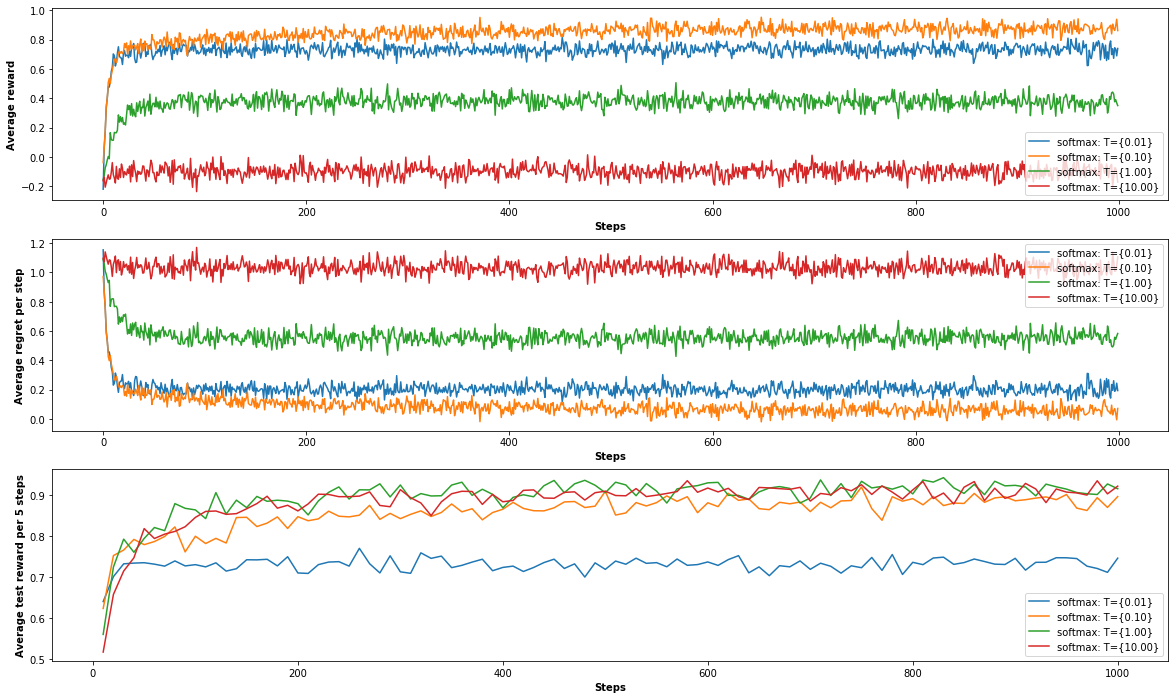

In [0]:
hyperparams_search({'softmax':[0.01,0.1,1,10]})

100%|██████████| 4/4 [02:04<00:00, 31.07s/it]


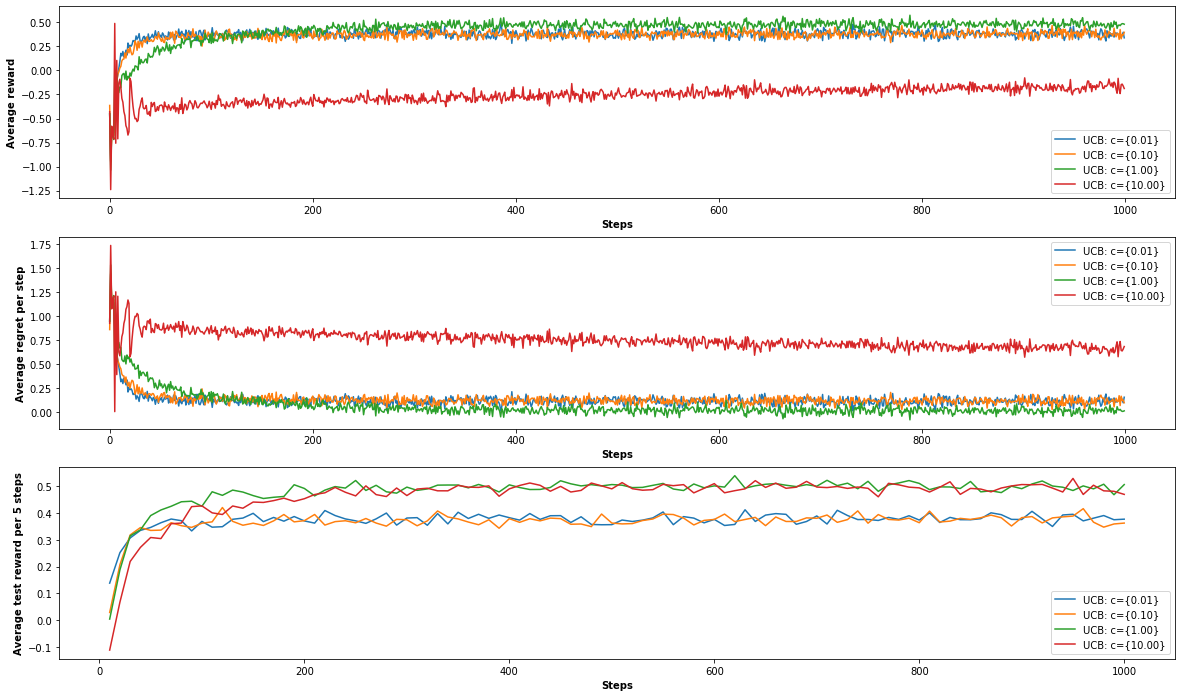

In [0]:
hyperparams_search({'UCB':[0.01,0.1,1,10]})

100%|██████████| 4/4 [02:37<00:00, 39.28s/it]


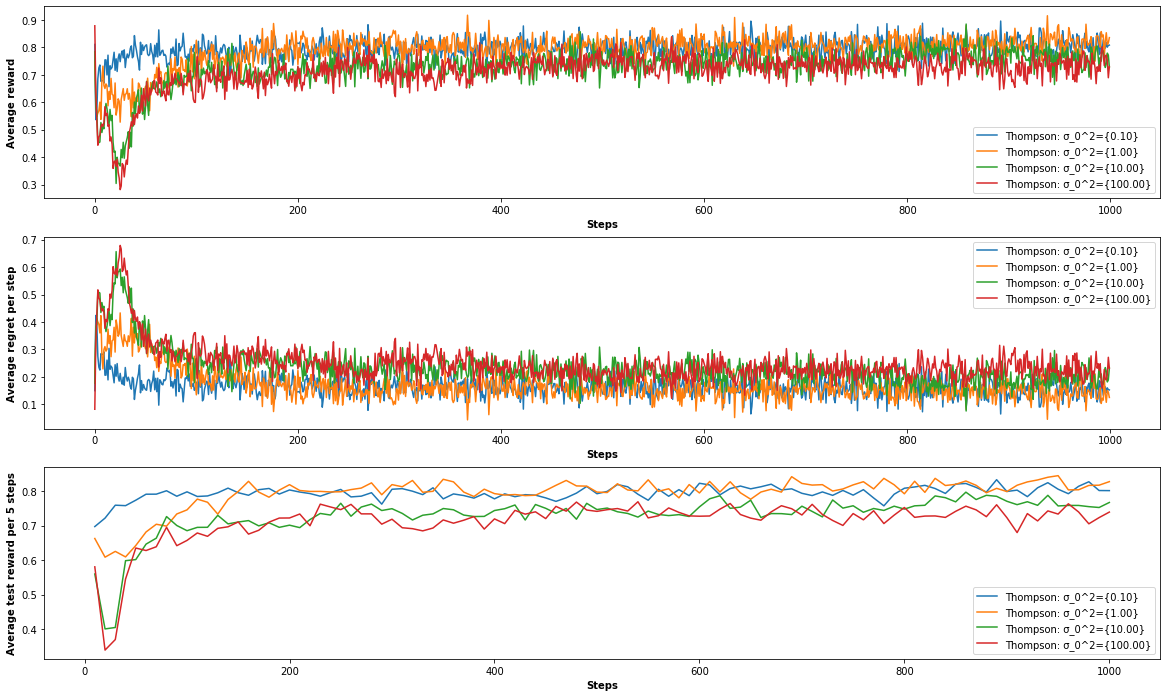

In [0]:
hyperparams_search({'Thompson':[0.1,1,10,100]})

100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


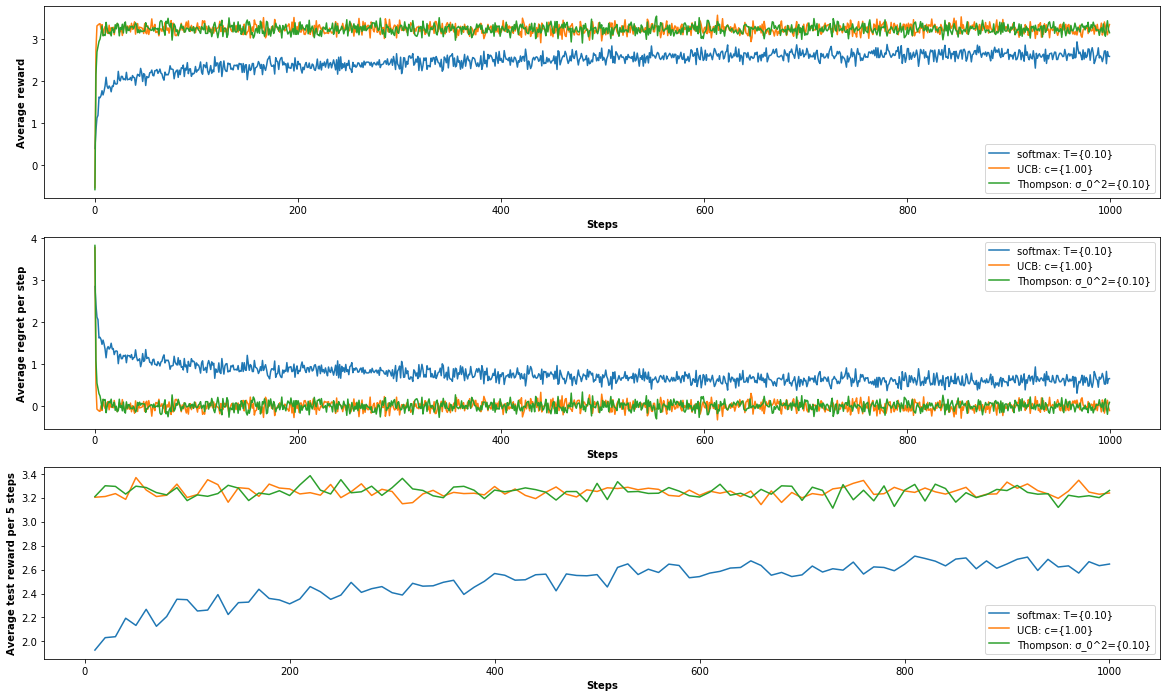

In [0]:
hyperparams_search({'softmax':[0.1],'UCB':[1],'Thompson':[0.1]},iterations=100)

### **Question 2.**

####Track A


##### **Miniword Environment Code, From Gym's Github**

In [0]:
# environment code, source: https://github.com/maximecb/gym-miniworld
# had trouble importing into colab
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.
    For example, a 4x4 grid looks as follows:
    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T
    x is your position and T are the two terminal states.
    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4,4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape)
        nA = 4

        MAX_Y = shape[0]
        MAX_X = shape[1]

        P = {}
        grid = np.arange(nS).reshape(shape)
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            # P[s][a] = (prob, next_state, reward, is_done)
            P[s] = {a : [] for a in range(nA)}

            is_done = lambda s: s == 0 or s == (nS - 1)
            reward = 0.0 if is_done(s) else -1.0

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            else:
                ns_up = s if y == 0 else s - MAX_X
                ns_right = s if x == (MAX_X - 1) else s + 1
                ns_down = s if y == (MAX_Y - 1) else s + MAX_X
                ns_left = s if x == 0 else s - 1
                P[s][UP] = [(1.0, ns_up, reward, is_done(ns_up))]
                P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
                P[s][DOWN] = [(1.0, ns_down, reward, is_done(ns_down))]
                P[s][LEFT] = [(1.0, ns_left, reward, is_done(ns_left))]

            it.iternext()

        # Initial state distribution is uniform
        isd = np.ones(nS) / nS

        # We expose the model of the environment for educational purposes
        # This should not be used in any model-free learning algorithm
        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        """ Renders the current gridworld layout
         For example, a 4x4 grid with the mode="human" looks like:
            T  o  o  o
            o  x  o  o
            o  o  o  o
            o  o  o  T
        where x is your position and T are the two terminal states.
        """
        if close:
            return

        outfile = io.StringIO() if mode == 'ansi' else sys.stdout

        grid = np.arange(self.nS).reshape(self.shape)
        it = np.nditer(grid, flags=['multi_index'])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            if self.s == s:
                output = " x "
            elif s == 0 or s == self.nS - 1:
                output = " T "
            else:
                output = " o "

            if x == 0:
                output = output.lstrip()
            if x == self.shape[1] - 1:
                output = output.rstrip()

            outfile.write(output)

            if x == self.shape[1] - 1:
                outfile.write("\n")

            it.iternext()

##### **Miniword Policy Iteraion Trial**

In [0]:
from IPython.core.debugger import set_trace
import numpy as np
import pprint
import sys
if "../" not in sys.path:
  sys.path.append("../") 

In [0]:
pp = pprint.PrettyPrinter(indent=2)
env = GridworldEnv()

def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value. Ref: Sutton book eq. 4.6.
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

random_policy = np.ones([env.nS, env.nA]) / env.nA
v = policy_eval(random_policy, env)

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Value Function:
[  0.         -13.99993529 -19.99990698 -21.99989761 -13.99993529
 -17.9999206  -19.99991379 -19.99991477 -19.99990698 -19.99991379
 -17.99992725 -13.99994569 -21.99989761 -19.99991477 -13.99994569
   0.        ]

Reshaped Grid Value Function:
[[  0.         -13.99993529 -19.99990698 -21.99989761]
 [-13.99993529 -17.9999206  -19.99991379 -19.99991477]
 [-19.99990698 -19.99991379 -17.99992725 -13.99994569]
 [-21.99989761 -19.99991477 -13.99994569   0.        ]]



##### **Policy Iteration = Policy Evaluation + Policy Improvement**

In [0]:
import gym
import itertools
import math
import matplotlib
import numpy as np
import pandas as pd
import random
import sys
import seaborn as sns

from gym.envs.registration import register
from matplotlib import pyplot as plt

In [0]:
def calculate_q_list(s, V, env, gamma):
    """
    Helper function to calculate the value for all action in a given state.
        
    Args:
        s: The state to consider (int)
        V: The value to use as an estimator, Vector of length env.nS
        
    Returns:
        A vector of length env.nA containing the expected value of each action.
    """
    A = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_s, reward, done in env.P[s][a]:
            A[a] += prob * (reward + gamma * V[next_s])
    return A

def policy_evaluation(Pi, V, env, gamma, theta=0.01, reward_wrapper=None):
    """ Policy Evaluation 
        Return: new value function mapping
    """
  
    while True:  # Loop for delta
        delta = 0  # reset delta
        for s in range(env.nS):  # Loop for each state
            v = V[s] 
            # V(s) <- \sum_a \pi(a|s) [r + \gamma V(s')]            
            new_v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(Pi[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value. Ref: Sutton book eq. 4.6.
                    new_v += action_prob * prob * (reward + gamma * V[next_state])
            
            """ Update delta"""
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - new_v))
            V[s] = new_v
            
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break

    return np.array(V)

def policy_improvement(Pi, V, env, gamma, reward_wrapper=None):
    """ Policy Improvement 
        Return: new policy function mapping
    """

    """ Set policy-stable <- true """
    policy_stable = True
    for s in range(env.nS):

        # old-action <- \pi(s)
        old_action = np.argmax(Pi[s])
        
        q_list = calculate_q_list(s, V, env, gamma=0.8)
        best_action = np.argmax(q_list)
        
        if old_action != best_action:
            policy_stable = False
        Pi[s] = np.eye(env.nA)[best_action]

    return policy_stable, Pi, V

def policy_iteration(env, gamma):
    # Start with a random policy
    V = np.zeros(env.nS)
    Pi = np.ones([env.nS, env.nA]) / env.nA
    
    for t in range(1000):
        # Evaluate the current policy
        V = policy_evaluation(Pi, V, env, gamma)
        
        Pi, V = policy_improvement(Pi, V, env, gamma)
        
        return Pi, V

###### Taxi via Policy Iteration

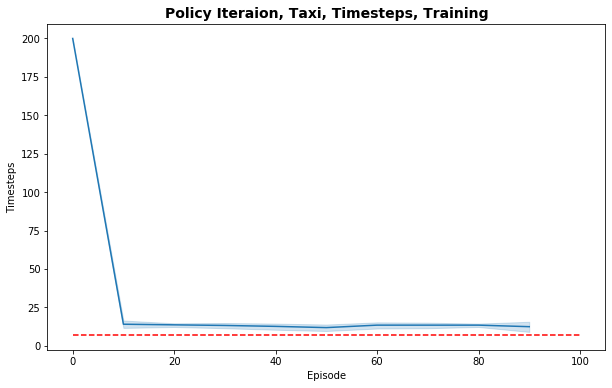

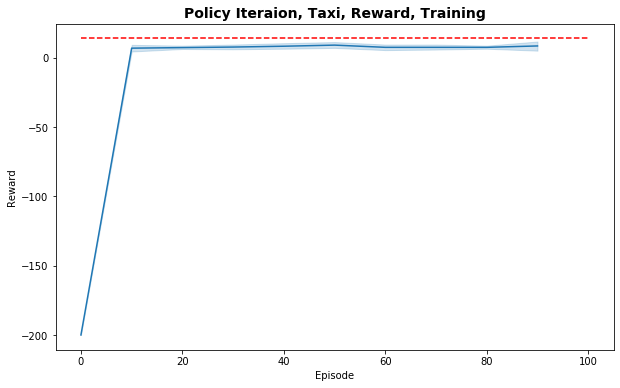

In [116]:
# hyperparameters
num_episodes = 100
gamma = 0.8  # discount factor

env = gym.make('Taxi-v3')

# initialize stats
log_freq = 1
num_log = int(num_episodes / log_freq)
stat_dataframe = pd.DataFrame(columns=['Episode', 'Reward', 'Timestemps']) 

# Start with a random policy
V_policy_taxi = np.zeros(env.nS)
Pi = np.ones([env.nS, env.nA]) / env.nA

for episode in range(num_episodes):
    
    """ Policy Evalution """
    V = policy_evaluation(Pi, V, env, gamma)
    """ Policy Improvement """
    policy_stable, Pi, V = policy_improvement(Pi, V, env, gamma) 

    if episode % 10 == 0:
        
        for test_id in range(5):  # Test 5 times
            
            cumu_reward = 0
            total_step = 0
            
            state = env.reset()
            for t in itertools.count():
                action = np.argmax(Pi[state])
                next_state, reward, done, _ = env.step(action)
                state = next_state

                # update stats
                cumu_reward += reward
                total_step += 1

                if done:
                    break
            
            stat_dataframe = stat_dataframe.append({'Episode': int(episode), 
                                                    'Reward': float(cumu_reward), 
                                                    'Timesteps': float(total_step)}, ignore_index=True,)

      # visualize results

plt.figure(figsize=(10,6))
plt.title("Policy Iteraion, Taxi, Timesteps, Training", fontsize=14, fontweight='bold')
ax1 = sns.lineplot(x="Episode", y="Timesteps", data=stat_dataframe)
plt.hlines(min(stat_dataframe["Timesteps"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()
plt.figure(figsize=(10,6))
plt.title("Policy Iteraion, Taxi, Reward, Training", fontsize=14, fontweight='bold')
ax2 = sns.lineplot(x="Episode", y="Reward", data=stat_dataframe)
plt.hlines(max(stat_dataframe["Reward"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()

env.close()

For Taxi, we can see that both rewards and timesteps converged quickly. The values plateaued at around 10 episodes, and since then there is not much improvements. We could say the policy iterations are effective.

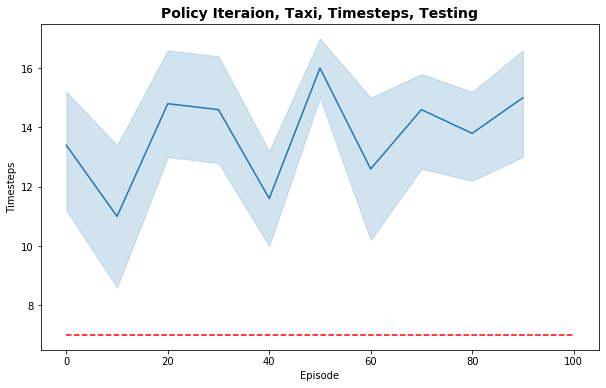

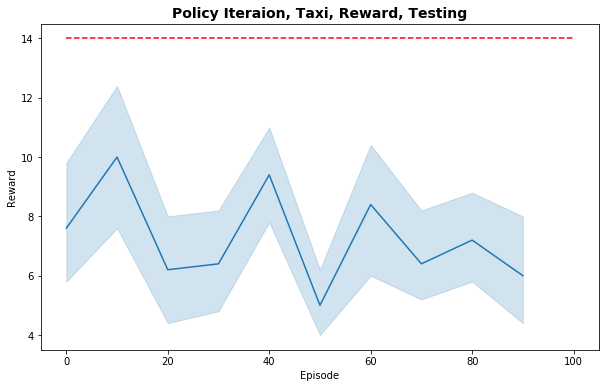

In [118]:
# hyperparameters
num_episodes = 100
gamma = 0.8  # discount factor

env = gym.make('Taxi-v3')

# initialize stats
log_freq = 1
num_log = int(num_episodes / log_freq)
stat_dataframe1 = pd.DataFrame(columns=['Episode', 'Reward', 'Timestemps']) 

for episode in range(num_episodes):
    
    """ Policy Evalution """
    V = policy_evaluation(Pi, V, env, gamma)
    """ Policy Improvement """
    policy_stable, Pi, V = policy_improvement(Pi, V, env, gamma) 

    if episode % 10 == 0:
        
        for test_id in range(5):  # Test 5 times
            
            cumu_reward = 0
            total_step = 0
            
            state = env.reset()
            for t in itertools.count():
                action = np.argmax(Pi[state])
                next_state, reward, done, _ = env.step(action)
                state = next_state

                # update stats
                cumu_reward += reward
                total_step += 1

                if done:
                    break
            
            stat_dataframe1 = stat_dataframe1.append({'Episode': int(episode), 
                                                    'Reward': float(cumu_reward), 
                                                    'Timesteps': float(total_step)}, ignore_index=True,)

      # visualize results

plt.figure(figsize=(10,6))
plt.title("Policy Iteraion, Taxi, Timesteps, Testing", fontsize=14, fontweight='bold')
ax1 = sns.lineplot(x="Episode", y="Timesteps", data=stat_dataframe1)
plt.hlines(min(stat_dataframe1["Timesteps"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()

plt.figure(figsize=(10,6))
plt.title("Policy Iteraion, Taxi, Reward, Testing", fontsize=14, fontweight='bold')
ax2 = sns.lineplot(x="Episode", y="Reward", data=stat_dataframe1)
plt.hlines(max(stat_dataframe1["Reward"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()

env.close()

Since training converged quite quickly, it is no surprise testing give consistent results with relatively low variations

###### FrozenLake via Policy Iteration

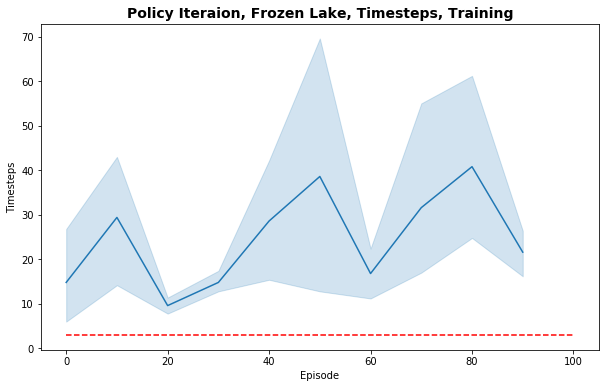

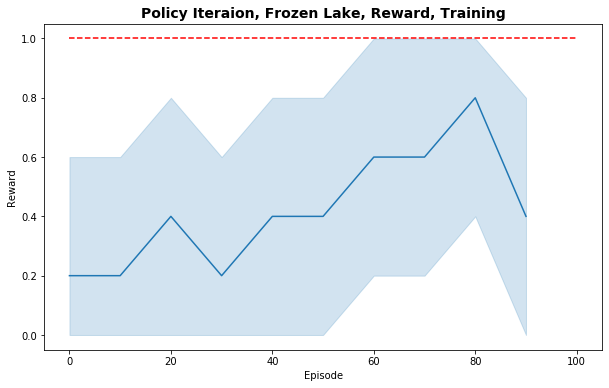

In [137]:
# hyperparameters
num_episodes = 100
gamma = 0.8  # discount factor

env = gym.make('FrozenLake-v0')

# initialize stats
log_freq = 1
num_log = int(num_episodes / log_freq)
stat_dataframe = pd.DataFrame(columns=['Episode', 'Reward', 'Timestemps']) 

# Start with a random policy
V = np.zeros(env.nS)
Pi = np.ones([env.nS, env.nA]) / env.nA

for episode in range(num_episodes):
    
    """ Policy Evalution """
    V = policy_evaluation(Pi, V, env, gamma)
    """ Policy Improvement """
    policy_stable, Pi, V = policy_improvement(Pi, V, env, gamma) 

    if episode % 10 == 0:
        
        for test_id in range(5):  # Test 5 times
            
            cumu_reward = 0
            total_step = 0
            
            state = env.reset()
            for t in itertools.count():
                action = np.argmax(Pi[state])
                next_state, reward, done, _ = env.step(action)
                state = next_state

                # update stats
                cumu_reward += reward
                total_step += 1

                if done:
                    break
            
            stat_dataframe = stat_dataframe.append({'Episode': int(episode), 
                                                    'Reward': float(cumu_reward), 
                                                    'Timesteps': float(total_step)}, ignore_index=True,)

plt.figure(figsize=(10,6))
plt.title("Policy Iteraion, Frozen Lake, Timesteps, Training", fontsize=14, fontweight='bold')
ax1 = sns.lineplot(x="Episode", y="Timesteps", data=stat_dataframe)
plt.hlines(min(stat_dataframe["Timesteps"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()

plt.figure(figsize=(10,6))
plt.title("Policy Iteraion, Frozen Lake, Reward, Training", fontsize=14, fontweight='bold')
ax2 = sns.lineplot(x="Episode", y="Reward", data=stat_dataframe)
plt.hlines(max(stat_dataframe["Reward"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()


env.close()

For frozen lake, the convergence was not good. The timesteps taken to solve the task did not improve much. The reward, however, stabilized at around 0.4 after some fluctuations

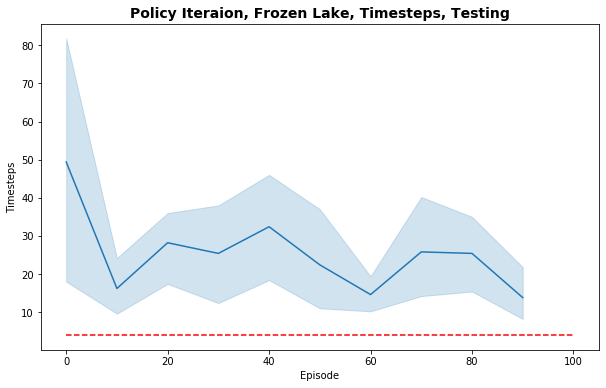

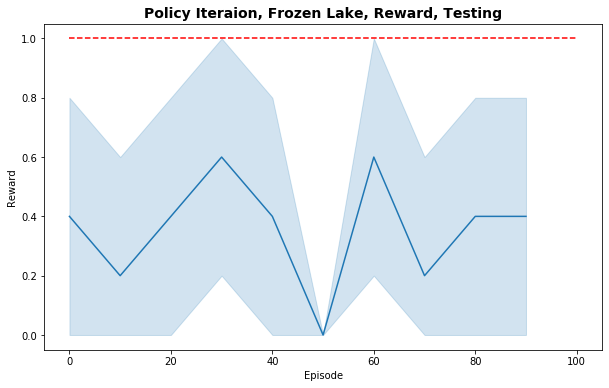

In [142]:
# hyperparameters
num_episodes = 100
gamma = 0.8  # discount factor

env = gym.make('FrozenLake-v0')

# initialize stats
log_freq = 1
num_log = int(num_episodes / log_freq)
stat_dataframe = pd.DataFrame(columns=['Episode', 'Reward', 'Timestemps']) 

for episode in range(num_episodes):
    
    """ Policy Evalution """
    V = policy_evaluation(Pi, V, env, gamma)
    """ Policy Improvement """
    policy_stable, Pi, V = policy_improvement(Pi, V, env, gamma) 

    if episode % 10 == 0:
        
        for test_id in range(5):  # Test 5 times
            
            cumu_reward = 0
            total_step = 0
            
            state = env.reset()
            for t in itertools.count():
                action = np.argmax(Pi[state])
                next_state, reward, done, _ = env.step(action)
                state = next_state

                # update stats
                cumu_reward += reward
                total_step += 1

                if done:
                    break
            
            stat_dataframe = stat_dataframe.append({'Episode': int(episode), 
                                                    'Reward': float(cumu_reward), 
                                                    'Timesteps': float(total_step)}, ignore_index=True,)

plt.figure(figsize=(10,6))
plt.title("Policy Iteraion, Frozen Lake, Timesteps, Testing", fontsize=14, fontweight='bold')
ax1 = sns.lineplot(x="Episode", y="Timesteps", data=stat_dataframe)
plt.hlines(min(stat_dataframe["Timesteps"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()

plt.figure(figsize=(10,6))
plt.title("Policy Iteraion, Frozen Lake, Reward, Testing", fontsize=14, fontweight='bold')
ax2 = sns.lineplot(x="Episode", y="Reward", data=stat_dataframe)
plt.hlines(max(stat_dataframe["Reward"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()


env.close()

Testing with a trained policy is much of the same story. The reward seem to fluctuate around 0.4 on average.

##### **Value Iteration Trials, lake + taxi**

In [0]:
import numpy as np
import pprint
import sys
import gym

pp = pprint.PrettyPrinter(indent=2)
Frozen_Lake = gym.make("FrozenLake-v0").env
Taxi = gym.make("Taxi-v3").env
named_env = [Frozen_Lake, Taxi]

def value_iteration(env, theta=0.01, discount_factor=0.8):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return policy, V

for env in named_env:
  policy, v = value_iteration(env)
  print(env)
  print("")
  print("Policy Probability Distribution:")
  print(policy)
  print("")
  if(policy.shape == (16,4)):
    print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
    print(np.reshape(np.argmax(policy, axis=1), [-1, policy.shape[0]]))
    print("")
  print("Value Function:")
  print(v)
  print("")
  if(v.shape == (16,)):
    print("Reshaped Grid Value Function:")
    print(v.reshape([4, 4]))
    print("")

<FrozenLakeEnv<FrozenLake-v0>>

Policy Probability Distribution:
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[1 3 2 3 0 0 0 0 3 1 0 0 0 2 1 0]]

Value Function:
[0.00364189 0.0065858  0.02016154 0.00898139 0.01287952 0.
 0.05486915 0.         0.04382656 0.1224216  0.19012087 0.
 0.         0.23673087 0.5393049  0.        ]

Reshaped Grid Value Function:
[[0.00364189 0.0065858  0.02016154 0.00898139]
 [0.01287952 0.         0.05486915 0.        ]
 [0.04382656 0.1224216  0.19012087 0.        ]
 [0.         0.23673087 0.5393049  0.        ]]

<TaxiEnv<Taxi-v3>>

Policy Probability Distribution:
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]

Value Function:

##### **Value Iteration**

In [0]:
def value_iteration(env, gamma, theta=0.01):
    
    V = np.zeros(env.nS)
    for t in itertools.count():
        delta = 0
        
        for s in range(env.nS):
            v = V[s]
            
            q_list = calculate_q_list(s, V, env, gamma)
            best_action_value = np.max(q_list)
            V[s] = best_action_value
            
            delta = max(delta, np.abs(best_action_value - v))
        
        if delta < theta:
            break
        
    """ Output policy """
    Pi = np.zeros([env.nS, env.nA])

    for s in range(env.nS):
        # value list
        q_list = calculate_q_list(s, V, env, gamma)
        best_action = np.argmax(q_list)
        Pi[s, best_action] = 1.0
    
    return Pi, V

# hyperparameters
num_episodes = 100
gamma = 0.8  # discount factor
theta = 0.01

###### Frozen lake via Value Iteration

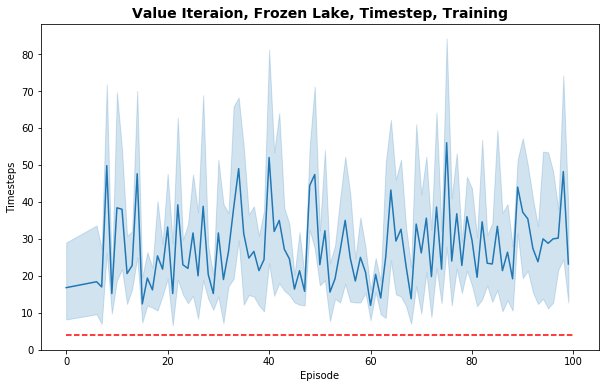

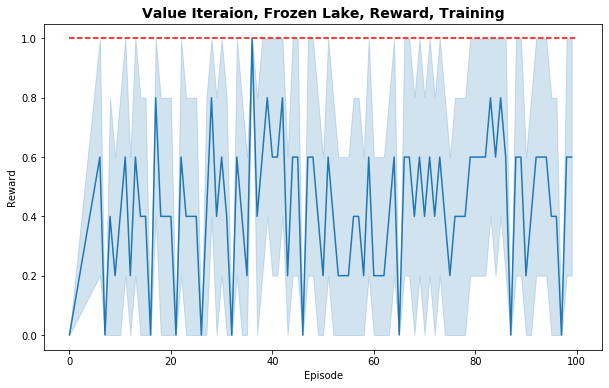

In [151]:
env = gym.make('FrozenLake-v0')

# initialize stats
log_freq = 1
num_log = int(num_episodes / log_freq)
stat_dataframe = pd.DataFrame(columns=['Episode', 'Reward', 'Timestemps']) 

# Start with a random policy
V = np.zeros(env.nS)

for episode in range(num_episodes):
    
    """ Value Iteration """
    delta = 0        
    for s in range(env.nS):
        v = V[s]
        q_list = calculate_q_list(s, V, env, gamma)
        best_action_value = np.max(q_list)
        V[s] = best_action_value
            
        delta = max(delta, np.abs(best_action_value - v))

    if delta < theta or episode % 10 == 0:
        
        """ Output policy """
        Pi = np.zeros([env.nS, env.nA])

        for s in range(env.nS):
            # value list
            q_list = calculate_q_list(s, V, env, gamma)
            best_action = np.argmax(q_list)
            Pi[s, best_action] = 1.0

        """ Test """
        for test_id in range(5):  # Test 5 times

            cumu_reward = 0
            total_step = 0

            state = env.reset()
            for t in itertools.count():
                action = np.argmax(Pi[state])
                next_state, reward, done, _ = env.step(action)
                state = next_state

                # update stats
                cumu_reward += reward
                total_step += 1

                if done:
                    break

            stat_dataframe = stat_dataframe.append({'Episode': int(episode), 
                                                    'Reward': float(cumu_reward), 
                                                    'Timesteps': float(total_step)}, ignore_index=True,)



plt.figure(figsize=(10,6))
plt.title("Value Iteraion, Frozen Lake, Timestep, Training", fontsize=14, fontweight='bold')
ax1 = sns.lineplot(x="Episode", y="Timesteps", data=stat_dataframe)
plt.hlines(min(stat_dataframe["Timesteps"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()
plt.figure(figsize=(10,6))
plt.title("Value Iteraion, Frozen Lake, Reward, Training", fontsize=14, fontweight='bold')
ax2 = sns.lineplot(x="Episode", y="Reward", data=stat_dataframe)
plt.hlines(max(stat_dataframe["Reward"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()
env.close()

Similar to policy iteration, the values given by value iteration are not very promising. However, similarly, the reward seem to be fluctuating around 0.4

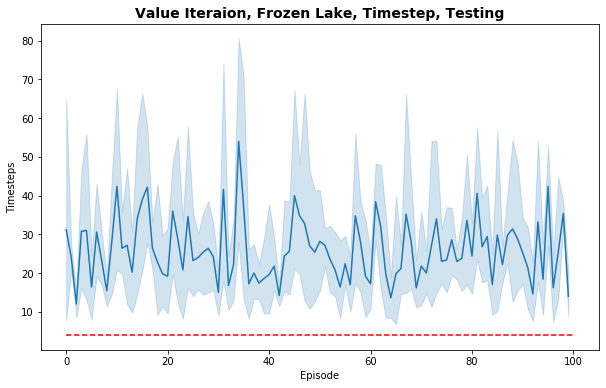

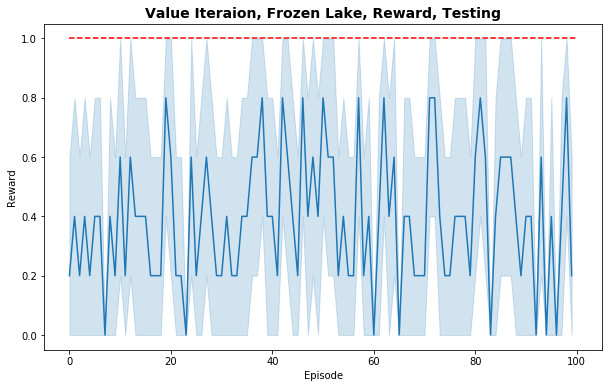

In [152]:
env = gym.make('FrozenLake-v0')

# initialize stats
log_freq = 1
num_log = int(num_episodes / log_freq)
stat_dataframe = pd.DataFrame(columns=['Episode', 'Reward', 'Timestemps']) 


for episode in range(num_episodes):
    
    """ Value Iteration """
    delta = 0        
    for s in range(env.nS):
        v = V[s]
        q_list = calculate_q_list(s, V, env, gamma)
        best_action_value = np.max(q_list)
        V[s] = best_action_value
            
        delta = max(delta, np.abs(best_action_value - v))

    if delta < theta or episode % 10 == 0:
        
        """ Output policy """
        Pi = np.zeros([env.nS, env.nA])

        for s in range(env.nS):
            # value list
            q_list = calculate_q_list(s, V, env, gamma)
            best_action = np.argmax(q_list)
            Pi[s, best_action] = 1.0

        """ Test """
        for test_id in range(5):  # Test 5 times

            cumu_reward = 0
            total_step = 0

            state = env.reset()
            for t in itertools.count():
                action = np.argmax(Pi[state])
                next_state, reward, done, _ = env.step(action)
                state = next_state

                # update stats
                cumu_reward += reward
                total_step += 1

                if done:
                    break

            stat_dataframe = stat_dataframe.append({'Episode': int(episode), 
                                                    'Reward': float(cumu_reward), 
                                                    'Timesteps': float(total_step)}, ignore_index=True,)



plt.figure(figsize=(10,6))
plt.title("Value Iteraion, Frozen Lake, Timestep, Testing", fontsize=14, fontweight='bold')
ax1 = sns.lineplot(x="Episode", y="Timesteps", data=stat_dataframe)
plt.hlines(min(stat_dataframe["Timesteps"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()
plt.figure(figsize=(10,6))
plt.title("Value Iteraion, Frozen Lake, Reward, Testing", fontsize=14, fontweight='bold')
ax2 = sns.lineplot(x="Episode", y="Reward", data=stat_dataframe)
plt.hlines(max(stat_dataframe["Reward"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()
env.close()

Similar to policy iteration, the values given by value iteration are not very promising. However, similarly, the reward seem to be fluctuating around 0.4 again for testing

###### Taxi via Value Iteration

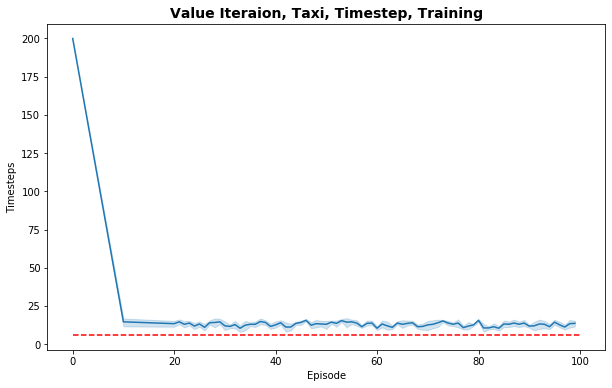

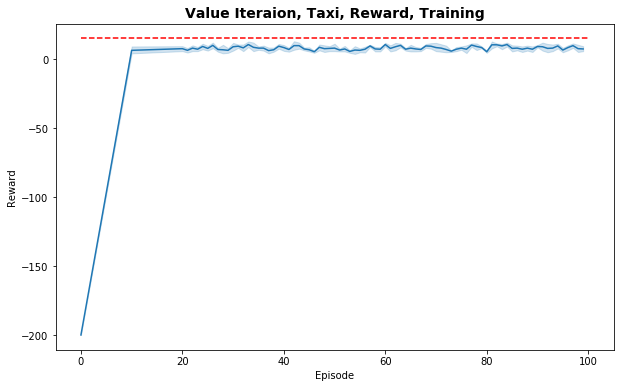

In [155]:
env = gym.make('Taxi-v3')

# initialize stats
log_freq = 1
num_log = int(num_episodes / log_freq)
stat_dataframe = pd.DataFrame(columns=['Episode', 'Reward', 'Timestemps']) 

# Start with a random policy
V = np.zeros(env.nS)

for episode in range(num_episodes):
    
    """ Value Iteration """
    delta = 0        
    for s in range(env.nS):
        v = V[s]
        q_list = calculate_q_list(s, V, env, gamma)
        best_action_value = np.max(q_list)
        V[s] = best_action_value
            
        delta = max(delta, np.abs(best_action_value - v))

    if delta < theta or episode % 10 == 0:
        
        """ Output policy """
        Pi = np.zeros([env.nS, env.nA])

        for s in range(env.nS):
            # value list
            q_list = calculate_q_list(s, V, env, gamma)
            best_action = np.argmax(q_list)
            Pi[s, best_action] = 1.0

        """ Test """
        for test_id in range(5):  # Test 5 times

            cumu_reward = 0
            total_step = 0

            state = env.reset()
            for t in itertools.count():
                action = np.argmax(Pi[state])
                next_state, reward, done, _ = env.step(action)
                state = next_state

                # update stats
                cumu_reward += reward
                total_step += 1

                if done:
                    break

            stat_dataframe = stat_dataframe.append({'Episode': int(episode), 
                                                    'Reward': float(cumu_reward), 
                                                    'Timesteps': float(total_step)}, ignore_index=True,)

plt.figure(figsize=(10,6))
plt.title("Value Iteraion, Taxi, Timestep, Training", fontsize=14, fontweight='bold')
ax2 = sns.lineplot(x="Episode", y="Timesteps", data=stat_dataframe)
plt.hlines(min(stat_dataframe["Timesteps"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()

plt.figure(figsize=(10,6))
plt.title("Value Iteraion, Taxi, Reward, Training", fontsize=14, fontweight='bold')
ax2 = sns.lineplot(x="Episode", y="Reward", data=stat_dataframe)
plt.hlines(max(stat_dataframe["Reward"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()

Same as policy iteration, convegence happened quickly in trainig taxi environment for both timestep and reward. So we should see little different for testing

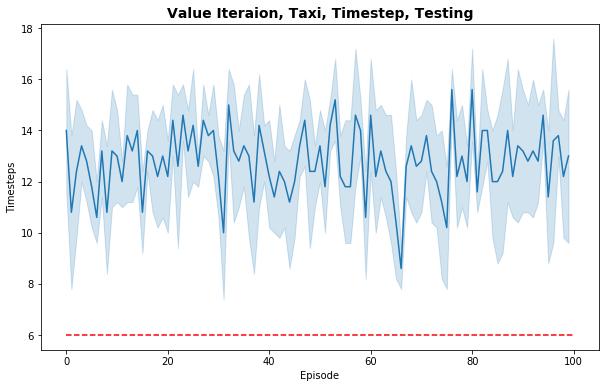

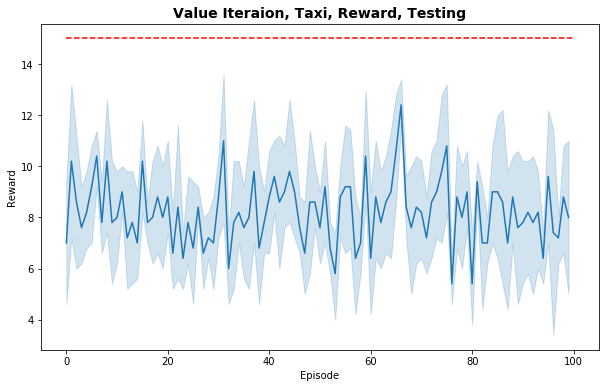

In [156]:
env = gym.make('Taxi-v3')

# initialize stats
log_freq = 1
num_log = int(num_episodes / log_freq)
stat_dataframe = pd.DataFrame(columns=['Episode', 'Reward', 'Timestemps']) 

for episode in range(num_episodes):
    
    """ Value Iteration """
    delta = 0        
    for s in range(env.nS):
        v = V[s]
        q_list = calculate_q_list(s, V, env, gamma)
        best_action_value = np.max(q_list)
        V[s] = best_action_value
            
        delta = max(delta, np.abs(best_action_value - v))

    if delta < theta or episode % 10 == 0:
        
        """ Output policy """
        Pi = np.zeros([env.nS, env.nA])

        for s in range(env.nS):
            # value list
            q_list = calculate_q_list(s, V, env, gamma)
            best_action = np.argmax(q_list)
            Pi[s, best_action] = 1.0

        """ Test """
        for test_id in range(5):  # Test 5 times

            cumu_reward = 0
            total_step = 0

            state = env.reset()
            for t in itertools.count():
                action = np.argmax(Pi[state])
                next_state, reward, done, _ = env.step(action)
                state = next_state

                # update stats
                cumu_reward += reward
                total_step += 1

                if done:
                    break

            stat_dataframe = stat_dataframe.append({'Episode': int(episode), 
                                                    'Reward': float(cumu_reward), 
                                                    'Timesteps': float(total_step)}, ignore_index=True,)

plt.figure(figsize=(10,6))
plt.title("Value Iteraion, Taxi, Timestep, Testing", fontsize=14, fontweight='bold')
ax2 = sns.lineplot(x="Episode", y="Timesteps", data=stat_dataframe)
plt.hlines(min(stat_dataframe["Timesteps"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()

plt.figure(figsize=(10,6))
plt.title("Value Iteraion, Taxi, Reward, Testing", fontsize=14, fontweight='bold')
ax2 = sns.lineplot(x="Episode", y="Reward", data=stat_dataframe)
plt.hlines(max(stat_dataframe["Reward"]), 0, num_log, colors = "r", linestyles = "dashed")
plt.show()

And unsurprisingly the values are rather consistent with little variations.

##### **Complexity Analysis**

Let $S$ denote number of states and $A$ denote number of actions.


Value Iteration


*   Space Complexity: $O(|A|)$
*   Time Complexity: $O(|S|^2|A|)$

Policy Iteration

*   Space Complexity: $O(|A|)$
*   Time Complexity: $O(\frac{A^S}{S})$
